In this workbook, I will apply the K-Nearest Neighbours (KNN) algorithm in an attempt to categorise 4 species of the "cat" family using 3 features.


1. (Domestic) cat  


2. Eurasian lynx  


3. Cheetah  


4. Tiger  

The features I will be using are:

1. Body weight
2. Body length (excluding tail)
3. Height (at shoulder)

**Generating the data**

Parameters for the guassian distribution come from wikipedia.

In [148]:
import numpy as np
import pandas as pd

Features = pd.DataFrame()
Features.insert(0,'cat',['4-5','44-48','23-25'])
Features.insert(1, 'lynx',['12-30','76-99','55-75'])
Features.insert(2, 'cheetah',['21-72','110-150','67-94'])
Features.insert(3, 'tiger',['90-300','250-390','75-107'])
Features.insert(0, 'Feature',['weight (kg)','length (cm)','height (cm)'])
#Features.set_index('Feature',inplace=True)
Features

,Feature,cat,lynx,cheetah,tiger
0,weight (kg),4-5,12-30,21-72,90-300
1,length (cm),44-48,76-99,110-150,250-390
2,height (cm),23-25,55-75,67-94,75-107


We will generate data from the Guassian distribution such that ~87% of samples fall within the given range.  
Thus calculating sigma as such:  
1.5*sigma = (range/2)

In [83]:
from scipy.stats import norm
print(norm.cdf(1.5)-norm.cdf(-1.5))

0.8663855974622838


In [84]:
import numpy as np
import pandas as pd

cat = []
for i in range(250):
    cat.append([np.random.normal(4.5,1/3), np.random.normal(46,4/3), np.random.normal(24,2/3), "cat"])
cat = np.array(cat)

lynx = []
for i in range(250):
    lynx.append([np.random.normal(21,6), np.random.normal(87.5,23/3), np.random.normal(65,20/3), "lynx"])
lynx = np.array(lynx)

cheetah = []
for i in range(250):
    cheetah.append([np.random.normal(46.5,17), np.random.normal(130,40/3), np.random.normal(80.5,9), "cheetah"])
cheetah = np.array(cheetah)
    
tiger = []
for i in range(250):
    tiger.append([np.random.normal(195,70), np.random.normal(320,140/3), np.random.normal(91,32/3), "tiger"])
tiger = np.array(tiger)

data = np.concatenate((cat, lynx, cheetah, tiger))
print(data)

[['4.13777284514264' '44.721759034236115' '23.92290190854106' 'cat']
 ['4.347610783065434' '46.75058020489249' '23.624258613077068' 'cat']
 ['4.600097853961544' '47.74486119705343' '24.49610451469156' 'cat']
 ...
 ['214.32995730273444' '262.567233879203' '82.9961462787855' 'tiger']
 ['207.41781410443176' '327.06757851605465' '116.77162711812434' 'tiger']
 ['152.83308079809044' '360.763182718322' '103.0212009455802' 'tiger']]


In [85]:
from sklearn.model_selection import train_test_split

X, y = data[:,0:3], data[:,3]
X = X.astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

**Implementing KNN algorithm**

In [86]:
def euclidean_distance(x1, x2): # cartesian pythag
    return np.sqrt(np.sum(x1-x2)**2)


class KNN:
    def __init__(self, k): # k is the number of closest neighbouring points used in classifying a single point
        self.k = k
        
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        
    def predict(self, X):
        predicted_labels = [self._predict(x) for x in X] # repeat _predict function for all test points
        return np.array(predicted_labels)
    
    def _predict(self, X): # find distances from one test point to all training points
        distances = [euclidean_distance(X, x_train) for x_train in self.X_train]
        k_nearest_distances = np.sort(distances)[:self.k]
        k_nearest_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_nearest_indices]
        
        # when the k-nearest points contains a split-vote, take the lowest total distance
        a = [k_nearest_labels.count(j) for j in k_nearest_labels]
        b = np.argwhere([i for i in a] == np.max([i for i in a]))
        c = []
        for u in range(len(b)):
            c.append(b[u][0])
        d = set([k_nearest_labels[o] for o in c])
        e = [q for q in d]

        if len(e) == 1:
            predicted_label = e[0]
        else:
            df = pd.DataFrame()
            df.insert(0,'labels',k_nearest_labels)
            df.insert(1,'distances',k_nearest_distances)
            df = df.groupby(by='labels',as_index=False,sort=False).sum()
            df = df.where(df['labels'].isin(e))
            df.dropna(inplace=True)
            df = df.where(df['distances'] == df['distances'].min())
            df.dropna(inplace=True)
            predicted_label = df['labels'].astype('str').values[0]
            
        
        return predicted_label

In [87]:
# test
knn = KNN(4)
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)
accuracy = np.sum([predictions==y_test])/len(y_test)
print(accuracy)

0.988


**Choosing a value of k**

In [88]:
K = list(range(1,11))
acc = []

for k in K:
    knn = KNN(k)
    knn.fit(X_train, y_train)
    predictions = knn.predict(X_test)
    accuracy = np.sum([predictions==y_test])/len(y_test)
    acc.append(accuracy)

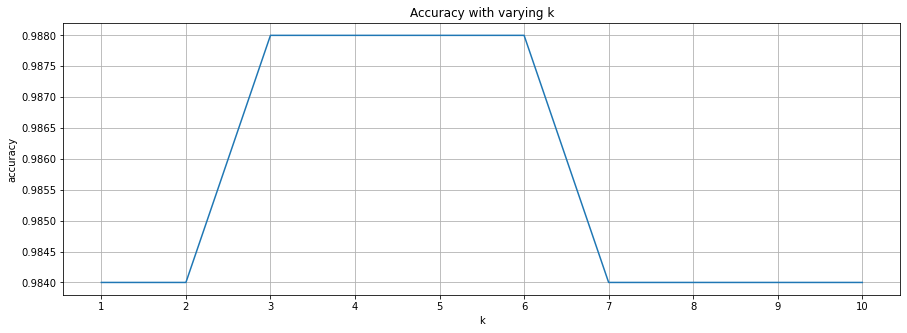

In [89]:
import matplotlib.pyplot as plt
plt.figure(figsize= [15,5])
plt.plot(K,acc)
plt.ylabel("accuracy")
plt.xlabel("k")
plt.xticks(K)
plt.title("Accuracy with varying k")
plt.grid()
plt.show()

We can choose k=3,4,5,6 but to reduce the risk of overfitting we will choose 5.

In [131]:
knn = KNN(5)
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)
accuracy = np.sum([predictions==y_test])/len(y_test)
print(accuracy)

0.988


In [132]:
df = pd.concat([pd.DataFrame(predictions), pd.DataFrame(y_test)], axis=1)
df.columns = ['predictions','y_test']
mismatch = df.where(df['predictions'] != df['y_test'])
mismatch = mismatch.dropna()
mismatch.value_counts()

predictions  y_test 
lynx         cheetah    3
dtype: int64

**Visualisations**

The errors came from incorrectly predicting cheetah as a lynx. Expected due to clusters for these two being the closest with the most overlap (see graph below).

Using weight and height to see an approximation of the grouping.  

**Test data with actual labels vs predicted labels**

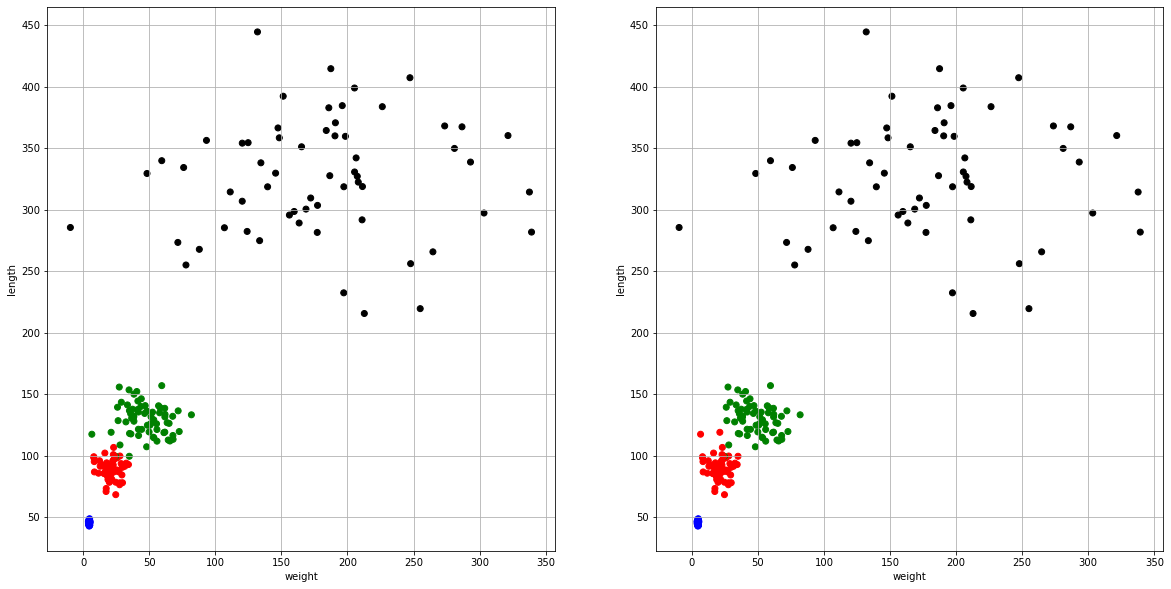

In [146]:
import matplotlib.pyplot

colmap = {
    "cat": "blue",
    "lynx": "red",
    "cheetah": "green",
    "tiger": "black"
}

colours = []
for i in y_test:
    colours.append(colmap[i])

colours2 = []
for i in predictions:
    colours2.append(colmap[i])


fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_figheight(10)
fig.set_figwidth(20)
ax1.scatter(X_test[:,0], X_test[:,1], c=colours)
ax1.set_xlabel('weight')
ax1.set_ylabel('length')
ax1.grid(True)

ax2.scatter(X_test[:,0], X_test[:,1], c=colours2)
ax2.set_xlabel('weight')
ax2.set_ylabel('length')
ax2.grid(True)

Comparing the 2 graphs, we can see the 3 cheetah (green) points that were predicted as lynx (red) due to the overlap in clusters.